In [1]:
pwd

'/home/jose/Desktop/Gitlab/hogan_lab/01_ESP/DMA_calibration'

# Reading results of SMPS

This script aims at reading and interpreting the results obtained by SMPS measurements.

In [2]:
from linker import *
%matplotlib notebook

In [3]:
k_B = 1.380650524e-23 # J/K
q_e = 1.602e-19       # C
Z_pti = 1

In [4]:
filepath = "measurements/tDMA-preeliminar/tDMA_test03/AIM4_5_25_2022.txt"

In [5]:
smps_data = smps2py.smps(filepath)
smps_data.data.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c43,c44,c45,c46,c47,c48,c49,c50,c51,c52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0000,8.1704,2.1044,8.73670,18.602,8.7481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.9192,1.9734,0.0000,3.2672,0.97819,24.814,32.6500
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0000,2.0432,0.0000,2.93920,60.136,32.6520
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0000,2.0432,0.0000,17.48000,81.154,130.6900
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0000,0.0000,0.0000,2.1051,119.85000,92.838,58.3120


In [6]:
class DMA():
    """
        This class is used to gather all the parameters
        of the studied DMA.
    """
    def __init__(self, DMA_props):
        self.model = DMA_props["model"]
        self.flow_aerosol = DMA_props["flow_aerosol"]   # L/min
        self.flow_sheath = DMA_props["flow_sheath"]     # L/min
        #self.flow_sampling = DMA_props["flow_sampling"] # L/min
        self.R1 = DMA_props["R1"]         # m
        self.R2 = DMA_props["R2"]         # m
        self.L = DMA_props["L"]           # m
        self.L_eff = DMA_props["L_eff"]   # m
        # nano DMA: self.L = 4.987e-02    # m
        self.A = self.L/np.log(self.R2/self.R1)
        self.V = DMA_props["Voltage"]     # V
        self.Zp = (2*self.flow_sheath)*(1.66667e-5)/(4*np.pi*self.A*self.V)
        # Ambient properties
        self.Pressure = DMA_props["Pressure"]       # Pa
        self.Temperature = DMA_props["Temperature"] # K
        self.Charge_limit = DMA_props["Charge_limit"]
        return
    def Calculate_Zp(self, voltage):
        """
         Determine the electrical mobility (Zp) from
         the properties of the DMA and voltage.
         
         Be careful, flow_sheath is assumed in units: lpm
        """
        Zp = (2*self.flow_sheath)*(1.66667e-5)/(4*np.pi*self.A*voltage)
        return Zp
    def Update_voltage(self,new_V):
        if ((new_V > self.n_range[0]) and (new_V < self.n_range[1])):
            self.V = new_V
            self.Zp = self.Calculate_Zp(new_V)
        else:
            print("Error: voltage out of range for this DMA")
            self.V = 0
            self.Zp = 0
        return
    def Electric_mobility(self,Dp,charge):
        f = DMA_tools.friction(Dp,self.Temperature)
        Z = charge * DMA_tools.q_e/f
        return Z

In [7]:
def Search_Dp(x):
    particle = Particle(x)
    return (particle["mobility"]-Z_pti)/Z_pti

def samesign(a, b):
        return a * b > 0

def bisect(func, low, high):
    'Find root of continuous function where f(low) and f(high) have opposite signs'

    assert not samesign(func(low), func(high))

    for i in range(54):
        midpoint = (low + high) / 2.0
        if samesign(func(low), func(midpoint)):
            low = midpoint
        else:
            high = midpoint

    return midpoint

In [8]:
# Gas dinamic viscosity
def Mu_gas(T_g):
    mu_g = (18.203E-6)*(293.15+110)/(T_g+110)*(T_g/293.15)**(1.5)
    return mu_g
# Gas mean free path
def Lambda_gas(T_g):
    P_g = 101300
    lambda_g = 66.5E-9*(101300/P_g)*(T_g/293.15)*(1+110/293.15)/(1+110/T_g)
    return lambda_g
# Gas Knudsen number
def GET_Cc(R,T_g):
    A1 = 1.142
    A2 = 0.558
    A3 = 0.999
    lambda_g = Lambda_gas(T_g)
    Kn = lambda_g/R
    return 1 + A1*Kn + A2*Kn*np.exp(-A3/Kn)
# Friction coefficient
def friction(Dp,T_g):
    mu_g = Mu_gas(T_g)
    Cc = GET_Cc(Dp*0.5,T_g)
    f =  3*np.pi*mu_g*Dp/Cc
    return f

def Particle(dp_new):
    T_g=300
    q = 1
    f = friction(dp_new,T_g)
    particle = {"diameter": dp_new,
                "friction": f,
                "mobility": q*q_e/f}
    return particle

def Search_peaks(DMA_props):
    # Define the DMA properties
    global Z_pti
    dma1 = DMA(DMA_props)
    # 1 charge
    Z_pti = dma1.Zp/1
    Dp_1 = bisect(Search_Dp, 1e-09, 1e-03)
    # 2 charge
    Z_pti = dma1.Zp/2
    Dp_2 = bisect(Search_Dp, 1e-09, 1e-03)
    # 3 charge
    Z_pti = dma1.Zp/3
    Dp_3 = bisect(Search_Dp, 1e-09, 1e-03)
    # 4 charge
    Z_pti = dma1.Zp/4
    Dp_4 = bisect(Search_Dp, 1e-09, 1e-03)
    # 5 charge
    Z_pti = dma1.Zp/5
    Dp_5 = bisect(Search_Dp, 1e-09, 1e-03)
    peaks = np.array([Dp_1,Dp_2,Dp_3,Dp_4,Dp_5])
    return peaks

In [9]:
def Plot_peaks(fig, ax1, peaks):
    color = ["blue","red","green","black","cyan"]
    for i in range(len(peaks)):
        Dp = peaks[i] * 1e+09
        plt.axvline(x=Dp,
                    label=str(round(Dp,1))+" nm; "+
                    str(i+1)+" charges",
                    color=color[i])
    return

In [10]:
def Plot_results(export=False,ESP=False):
    fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80,
                            facecolor='w', edgecolor='k')
    plt.rc('xtick', labelsize=17)
    plt.rc('ytick', labelsize=17)
    if(ESP):
        title = "ESP ON"
    else:
        title = "ESP OFF"
    title = title + ", Q_sh="+str(round(Q_sh,2))+" lpm, nDMA v="+\
            str(nDMA_v/1000)+"kV ("+str(round(peaks[0]*(1e+09),1))+" nm)"
    plt.title(title,fontsize=17)
    plt.bar(smps_data.columns,smps_data.data.loc[sample-1], 
            color ='maroon',width = 10,label="SMPS scan")
    Plot_peaks(fig, ax1, peaks)
    #plt.yscale("log")
    #plt.xscale("log")
    ax1.set_xlabel('Mobility diameter $D_p$ (nm)', fontsize=20)
    ax1.set_ylabel('dN/dLog(Dp) (#/cm$^3$)', fontsize=20)
    plt.legend(fontsize=18, loc=0), plt.show()
    if(export):
        plt.savefig("RES_out/DMA_"+title+".png")
    return

<IPython.core.display.Javascript object>


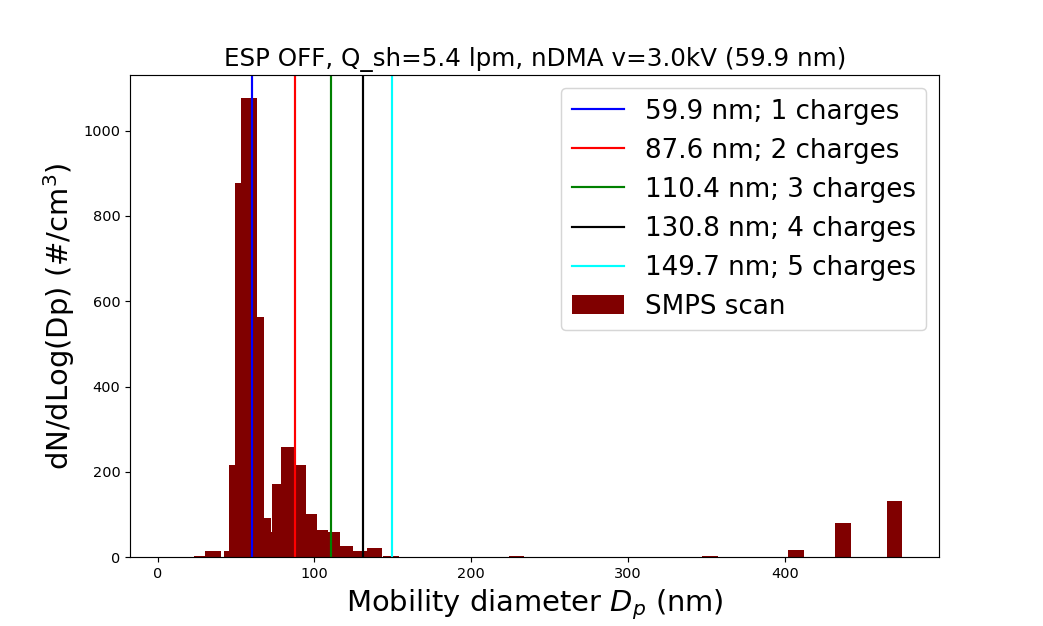

In [11]:
sample = 4
Q_sh = 5.4
nDMA_v = 3000

DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1,
    "flow_sheath":   Q_sh,
    "R1":            0.937e-02,
    "R2":            1.905e-02,
    "L":             4.987e-02,
    "Voltage":       nDMA_v,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  6} 

peaks = Search_peaks(DMA_props)

Plot_results(True)

<IPython.core.display.Javascript object>


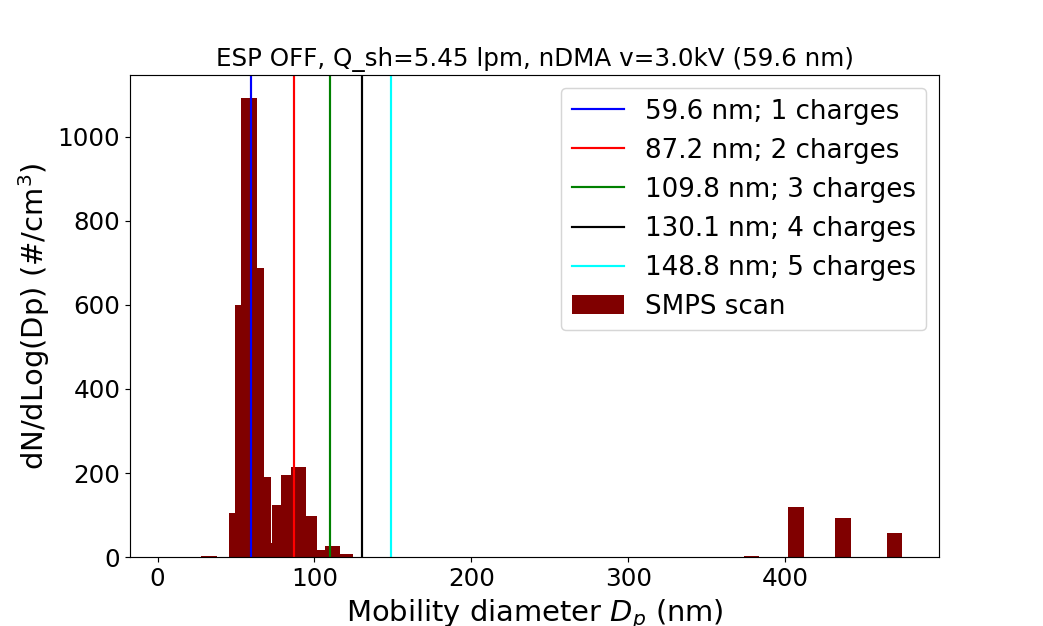

In [12]:
sample = 5
Q_sh = 5.45
nDMA_v = 3000

DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1,
    "flow_sheath":   Q_sh,
    "R1":            0.937e-02,
    "R2":            1.905e-02,
    "L":             4.987e-02,
    "Voltage":       nDMA_v,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  6} 

peaks = Search_peaks(DMA_props)

Plot_results(True)

<IPython.core.display.Javascript object>


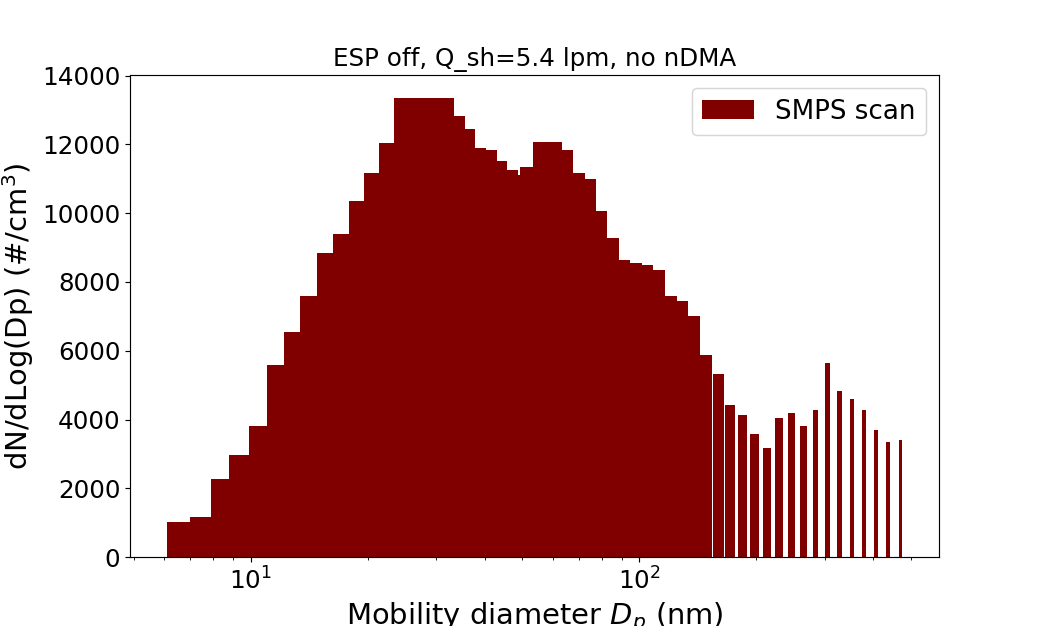

In [13]:
sample = 9
Q_sh = 5.4

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80,
                            facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
title = "ESP off, Q_sh="+str(round(Q_sh,2))+" lpm, no nDMA"
plt.title(title,fontsize=17)
plt.bar(smps_data.columns,smps_data.data.loc[sample-1], 
            color ='maroon',width = 10,label="SMPS scan")
plt.xscale("log")
ax1.set_xlabel('Mobility diameter $D_p$ (nm)', fontsize=20)
ax1.set_ylabel('dN/dLog(Dp) (#/cm$^3$)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()
plt.savefig("RES_out/No_nDMA_SMPS_scan.png")

<IPython.core.display.Javascript object>


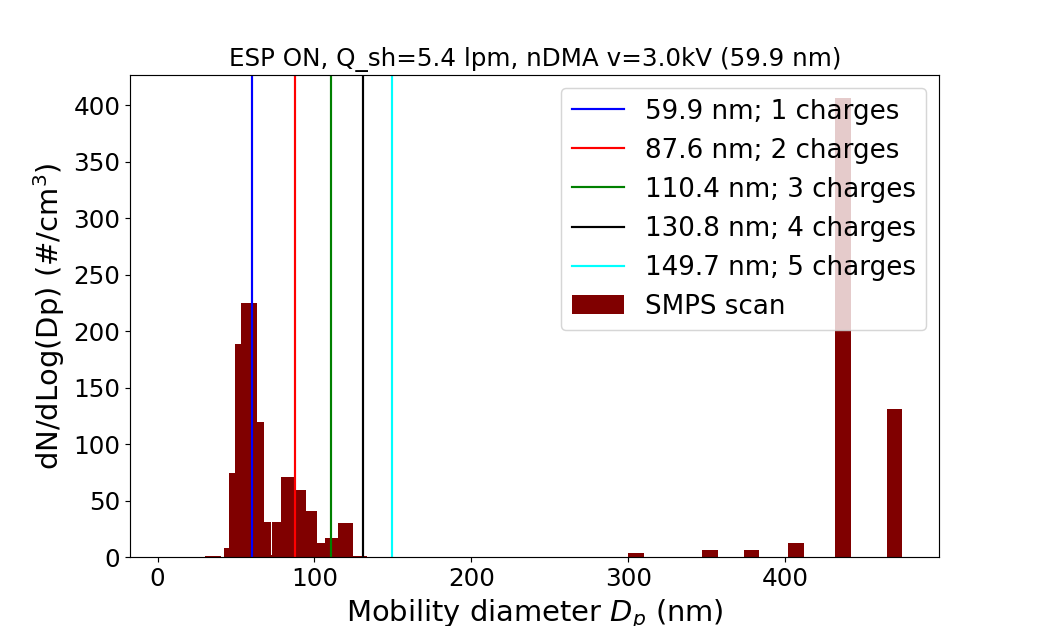

In [14]:
sample = 10
Q_sh = 5.4
nDMA_v = 3000

DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1,
    "flow_sheath":   Q_sh,
    "R1":            0.937e-02,
    "R2":            1.905e-02,
    "L":             4.987e-02,
    "Voltage":       nDMA_v,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  6} 

peaks = Search_peaks(DMA_props)

Plot_results(True,True)

<IPython.core.display.Javascript object>


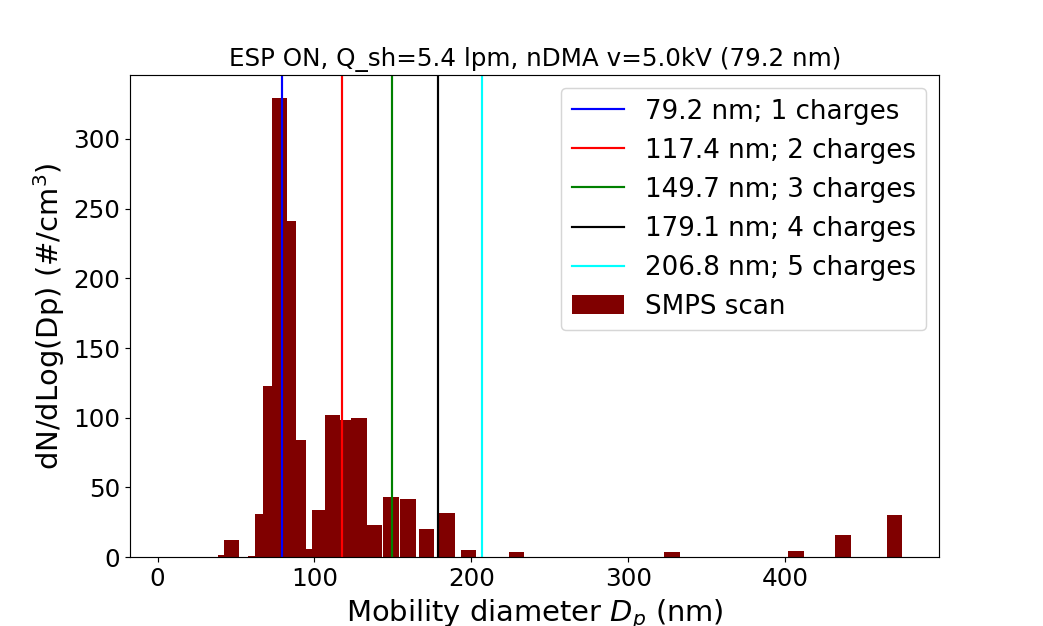

In [15]:
sample = 11
Q_sh = 5.4
nDMA_v = 5000

DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1,
    "flow_sheath":   Q_sh,
    "R1":            0.937e-02,
    "R2":            1.905e-02,
    "L":             4.987e-02,
    "Voltage":       nDMA_v,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  6} 

peaks = Search_peaks(DMA_props)

Plot_results(True,True)

<IPython.core.display.Javascript object>


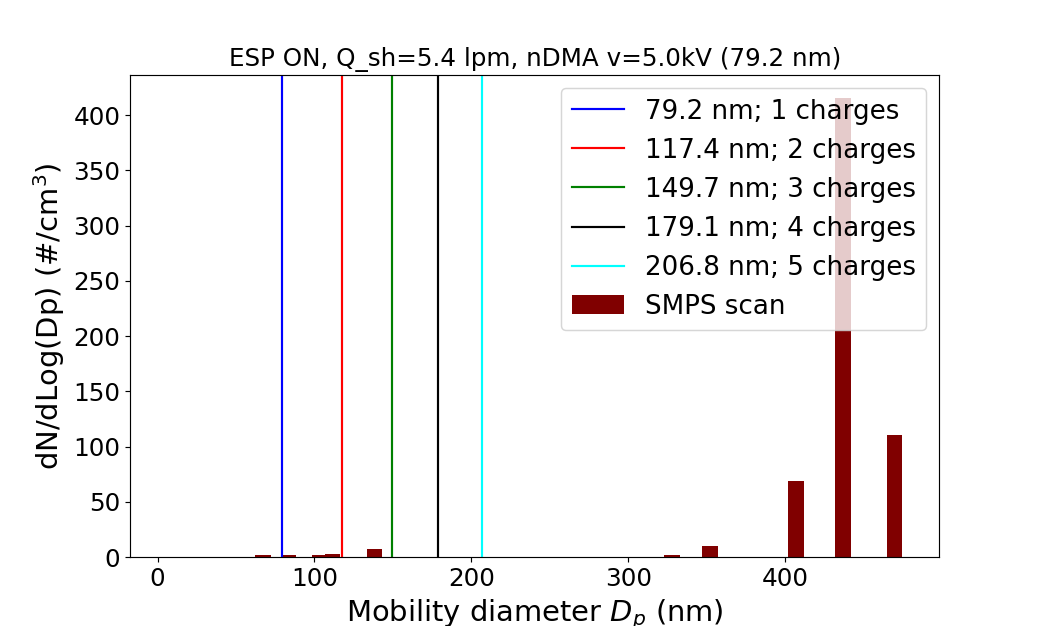

In [16]:
sample = 12
Q_sh = 5.4
nDMA_v = 5000

DMA_props = {
    "model":         "nano",
    "flow_aerosol":  1,
    "flow_sheath":   Q_sh,
    "R1":            0.937e-02,
    "R2":            1.905e-02,
    "L":             4.987e-02,
    "Voltage":       nDMA_v,
    "L_eff":         13,
    "Pressure":      101000,
    "Temperature":   300,
    "Charge_limit":  6} 

peaks = Search_peaks(DMA_props)

Plot_results(True,True)